In [ ]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import scipy.fft as spfft
import scipy.stats as sps
import scipy.optimize as spo
import scipy.interpolate as spi

import sklearn.linear_model as sklm
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [221]:
# EURUSD_M15, EURUSD_M5_V2
data = pd.read_csv("EURUSD_M5_V2.csv", sep = "\t")

In [212]:
def moving_average(series, n):
    smt_values = []
    for i in range(1, n):
        smt_values.append(np.NaN)
    for i in range(n, series.shape[0] + 1):
        smt_values.append(np.average(series[i - n:i]))
    return pd.Series(smt_values)

def exponential_smoothing(series, alpha):
    smt_values = np.empty(series.shape[0])
    smt_values[0] = series[0]
    for i in range(1, series.shape[0]):
        smt_values[i] = alpha * series[i] + (1 - alpha) * smt_values[i - 1]
    return pd.Series(smt_values)

def double_exponential_smoothing(series, alpha, beta):
    prediction = np.empty(series.shape[0])
    
    level, trend = series[0], 0
    prediction[0] = level + trend
    for i in range(1, series.shape[0]):
        prev_level, level = level, alpha * series[i] + (1 - alpha) * (level + trend)
        trend = beta * (level - prev_level) + (1 - beta) * trend
        prediction[i] = level + trend

    return pd.Series(prediction)

# ---

def acf_pacf_plot(series, lags):
    plt.figure(figsize = (20, 8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan = 2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    series.plot(ax = ts_ax)
    smt.graphics.plot_acf(series, lags = lags, ax = acf_ax)
    smt.graphics.plot_pacf(series, lags = lags, ax = pacf_ax)
    
    print('p_value =', smt.stattools.adfuller(series)[1])

def density_plot(resid):
    layout = (2, 1)
    plt.figure(figsize = (10, 8))
    err_ax = plt.subplot2grid(layout, (0, 0))
    dens_ax = plt.subplot2grid(layout, (1, 0))
    
    resid.plot(title = 'Residuals', ax = err_ax)
    resid.plot(kind = 'kde', title = 'Density', ax = dens_ax)

def best_parametrs(series, lags):
    acf = abs(smt.acf(series, nlags = lags)[1:])
    pacf = abs(smt.pacf(series, nlags = lags)[1:])
    
    bad_acf = np.array([i for i in range(acf.shape[0]) if acf[i] >= 0.05])
    bad_pacf = np.array([i for i in range(pacf.shape[0]) if pacf[i] >= 0.05])

    if bad_pacf.shape[0] == 0:
        p = 0
    else:
        p = bad_pacf[0] + 1
    # ---
    if bad_acf.shape[0] == 0:
        q = 0
    else:
        q = bad_acf[0] + 1

    return p, q

def nice_plot(data = [], label = []):
    plt.figure(figsize = (15, 5))
    for i in range(len(data)):
        plt.plot(data[i], label = label[i])
    plt.grid(which = 'major')
    plt.legend()

def my_filter(y, freq = 30):
    opt, cov = spo.curve_fit(approx_fun, np.arange(y.shape[0]), y)
    y_approx = approx_fun_arr(np.arange(y.shape[0]), opt)
    y_diff = y - y_approx
    # ---
    y_diff_ft = spfft.rfft(np.array(y_diff))
    y_diff_ft[freq:] = 0
    y_diff_new = spfft.irfft(y_diff_ft)
    # ---
    noise = y_diff - y_diff_new
    return y_approx, y_diff_new, noise

def approx_fun(x, a, b):
    return a + b * x

def approx_fun_arr(x, p):
    return p[0] + p[1] * x

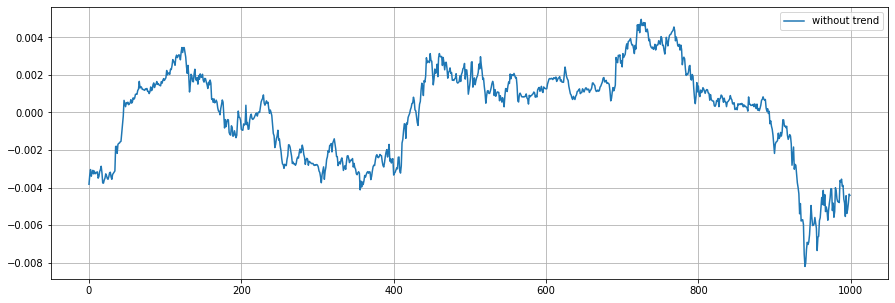

In [214]:
''' --- Разделяем на компоненты --- '''
y_full = data['<OPEN>'].reset_index(drop = True)
y = y_full[0:1000]
opt, cov = spo.curve_fit(approx_fun, np.arange(y.shape[0]), y)
y_approx = approx_fun_arr(np.arange(y.shape[0]), opt)
y_diff = y - y_approx

nice_plot([y_diff], ['without trend'])
# [y_full, y_approx, y_diff, y_diff.rolling(window = 12).mean()], ['data', 'approx', 'data_diff', 'data_diff']

-1.734723475976807e-21 0.0006427509870407795


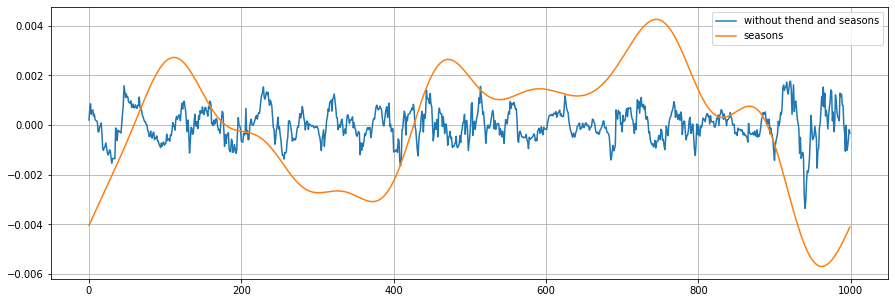

In [215]:
y_ft = spfft.rfft(np.array(y_diff))
y_ft[10:] = 0
y_diff_new = spfft.irfft(y_ft)
noise = y_diff - y_diff_new
nice_plot([noise, y_diff_new], ['without thend and seasons', 'seasons'])
print(noise.mean(), noise.std())

-1.734723475976807e-21 0.0006427509870407795


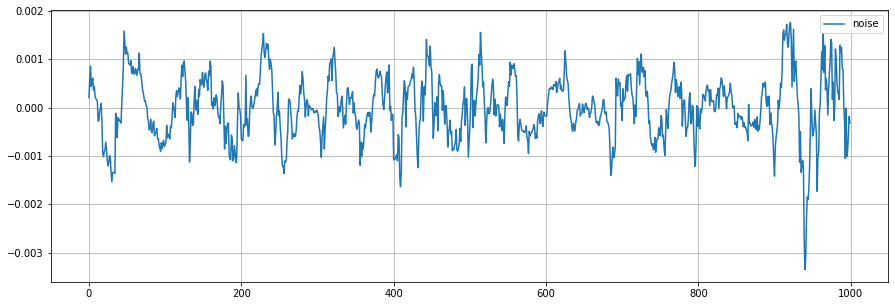

In [216]:
noise = y_diff - y_diff_new
# noise = noise.diff()
nice_plot([noise], ['noise'])
print(noise.mean(), noise.std())

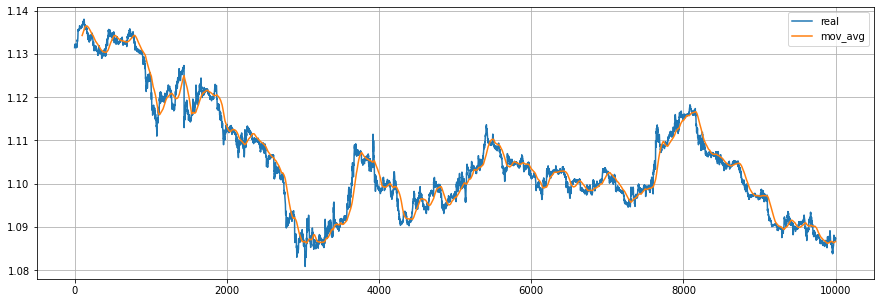

In [217]:
''' --- Сглаживание ряда --- '''
move = 0
y_full = data['<OPEN>'].reset_index(drop = True)
y = y_full[move:10000 + move].reset_index(drop = True)

# Берём разницу
for i in range(0):
    y = y.diff().dropna().reset_index(drop = True)

mov_avg = y.rolling(window = 100).mean().reset_index(drop = True)
nice_plot([y, mov_avg], ['real', 'mov_avg'])

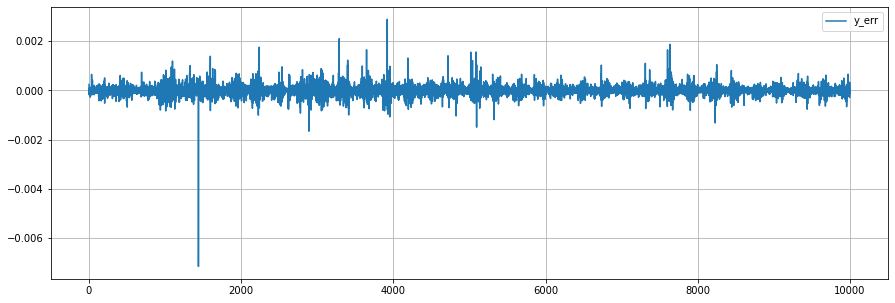

In [218]:
''' --- Смотрим погрешность реальных данных и сглаживания --- '''
y_full = data['<OPEN>'].reset_index(drop = True)
y = y_full[0:10000].reset_index(drop = True)

y_err = (y - y.rolling(window = 2).mean()).dropna().reset_index(drop = True)
nice_plot([y_err], ['y_err'])

p_value = 0.0


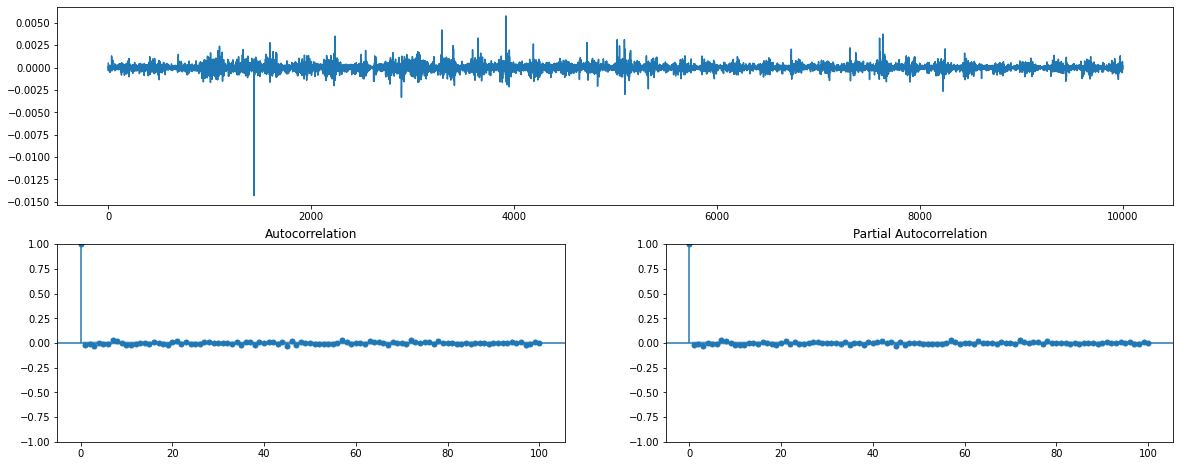

In [219]:
''' --- Проверка ряда на стационарность --- '''
move = 0
y_full = data['<OPEN>'].reset_index(drop = True)

# Сглаживание
#y_full = y_full.rolling(window = 10).mean().dropna().reset_index(drop = True)

# Исследуемая область
y = y_full[move:10000 + move].reset_index(drop = True)

# Ищем стационарный ряд
d = 1
y_nlag = y
for i in range(d):
    y_nlag = y_nlag.diff().dropna().reset_index(drop = True)

# Критерий Дики-Фуллера и графики автокорреляции и частичной автокорреляции
acf_pacf_plot(y_nlag, 100)

In [184]:
''' --- Построение и проверка качества модели --- '''
# Определяем лучшие параметры
p, q = best_parametrs(y_nlag, 50)
#p, q = 6, 3
print(f'p = {p}, q = {q}')

# Строим модель
model = smt.ARIMA(y, order = (p, d, q)).fit()

# Отчёт по модели
print(model.summary())

# Графики погрешностей и их функции распределения
# density_plot(model.resid[d:])

p = 0, q = 0
                               SARIMAX Results                                
Dep. Variable:                 <OPEN>   No. Observations:                10000
Model:                 ARIMA(0, 1, 0)   Log Likelihood               58225.619
Date:                Sun, 29 Jan 2023   AIC                        -116449.239
Time:                        10:51:27   BIC                        -116442.028
Sample:                             0   HQIC                       -116446.798
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.123e-07   2.76e-09    185.767      0.000    5.07e-07    5.18e-07
Ljung-Box (L1) (Q):                  20.34   Jarque-Bera (JB):             57919.85
Prob(Q):                          

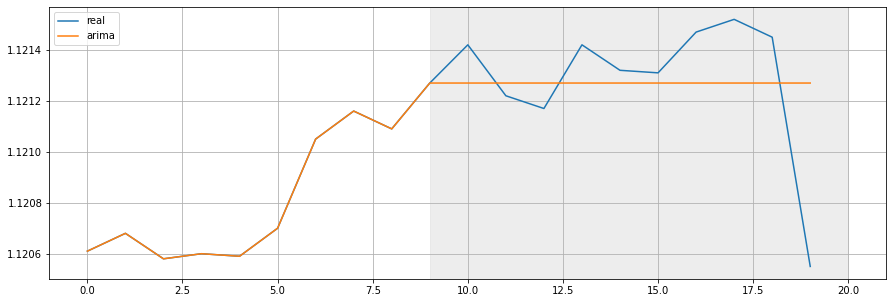

In [185]:
''' --- Предсказание модели --- '''
start, end = y.shape[0] - 10, y.shape[0] + 10
forecast = model.predict(start = start + 1, end = end).values

plt.figure(figsize = (15, 5))
plt.plot(y_full[start + move:end + move].values, label = 'real')
plt.plot(forecast, label = 'arima')
plt.axvspan(y.shape[0] - start - 1, end - start, alpha= 0.4, color = 'lightgray')
plt.grid(which = 'major')
plt.legend()

In [222]:
def prepareData(series, lag_start = 5, lag_end = 20, test_size = 0.25):
    # Подготовка данных
    data = pd.DataFrame()
    data['result'] = series
    series_diff = series.diff()
    for i in range(lag_start, lag_end - 1):
        data[f'lag_diff{i}'] = series_diff.shift(i)
    data['mov_avg'] = series.rolling(window = lag_end - lag_start).mean().shift(lag_start)
    #print(data)
    
    data = data.dropna().reset_index(drop = True)
    # Сплит данных
    test_index = int(data.shape[0] * (1 - test_size))

    X_train = data.iloc[:test_index].drop(['result'], axis = 1).reset_index(drop = True)
    Y_train = data['result'][:test_index].reset_index(drop = True)
    X_test = data.iloc[test_index:].drop(['result'], axis = 1).reset_index(drop = True)
    Y_test = data['result'][test_index:].reset_index(drop = True)

    return X_train, Y_train, X_test, Y_test

1.258158232465444e-07 0.000232644715200642


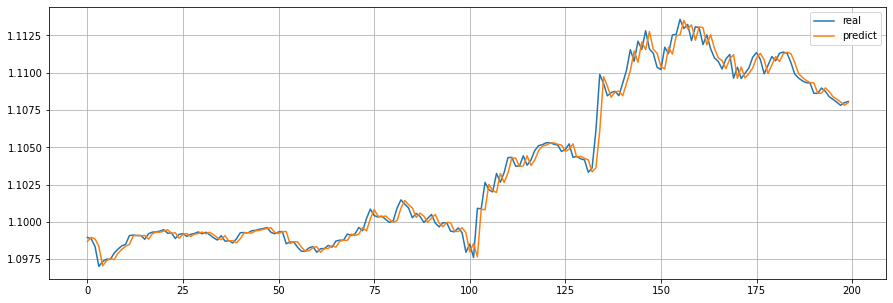

In [223]:
''' --- Регрессия --- '''

y_full = data['<OPEN>'].reset_index(drop = True)
y = y_full[0:10000].reset_index(drop = True)
# y = y.diff().dropna().reset_index(drop = True)

# Сплит данных
lag_start, lag_end = 1, 5
X_train, Y_train, X_test, Y_test = prepareData(y, lag_start = lag_start, lag_end = lag_end, test_size = 0.25)
# XY = pd.concat([pd.concat([Y_train, Y_test], axis = 0), pd.concat([X_train, X_test], axis = 0)], axis = 1).reset_index(drop = True)

# Линейные модели --- sklm. |--------------| другие методы --- ensemble.
lr = sklm.LinearRegression()
lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)

# Погрешность
print(mean_squared_error(Y_test, Y_pred), mean_absolute_error(Y_test, Y_pred))

nice_plot([Y_test[:200], Y_pred[:200]], ['real', 'predict'])

In [14]:
y_full = data['<OPEN>'].reset_index(drop = True)
y = y_full[0:1000].reset_index(drop = True)
lag_start, lag_end = 1, 4

y_data = pd.DataFrame()
y_data['result'] = y.rolling(window = lag_end - lag_start).mean()
y_diff = y.diff()
for i in range(lag_start, lag_end - 1):
    y_data[f'lag_diff{i}'] = y_diff.shift(i)
y_data['mov_avg'] = y.rolling(window = lag_end - lag_start).mean().shift(lag_start)
y_data['mov_std'] = y.rolling(window = lag_end - lag_start).std().shift(lag_start)
print(y_data)

y_data = y_data.dropna().reset_index(drop = True)

       result  lag_diff1  lag_diff2   mov_avg   mov_std
0         NaN        NaN        NaN       NaN       NaN
1         NaN        NaN        NaN       NaN       NaN
2    1.131867    0.00048        NaN       NaN       NaN
3    1.132003    0.00029    0.00048  1.131867  0.000389
4    1.132040   -0.00036    0.00029  1.132003  0.000191
..        ...        ...        ...       ...       ...
995  1.124067    0.00110   -0.00072  1.124257  0.000559
996  1.124183   -0.00095    0.00110  1.124067  0.000597
997  1.124047    0.00020   -0.00095  1.124183  0.000501
998  1.124383    0.00034    0.00020  1.124047  0.000273
999  1.124630    0.00047    0.00034  1.124383  0.000407

[1000 rows x 5 columns]


In [15]:
y_data.corr()

,result,lag_diff1,lag_diff2,mov_avg,mov_std
result,1.000000,0.043174,0.079161,0.998306,-0.281356
lag_diff1,0.043174,1.000000,-0.064789,0.012456,-0.044600
lag_diff2,0.079161,-0.064789,1.000000,0.046811,-0.052664
mov_avg,0.998306,0.012456,0.046811,1.000000,-0.279196
mov_std,-0.281356,-0.044600,-0.052664,-0.279196,1.000000


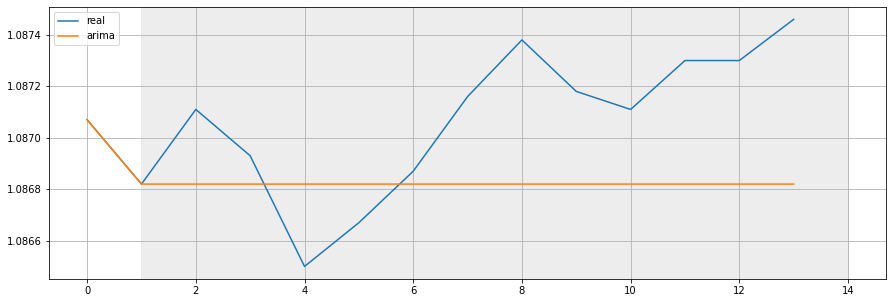

In [225]:
def i_want_to_see_prediction(move = 0):
    y_full = data['<OPEN>'].reset_index(drop = True)
    y = y_full[move:10000 + move].reset_index(drop = True)

    y_nlag = y
    for i in range(d):
        y_nlag = y_nlag.diff().dropna().reset_index(drop = True)

    p, q = best_parametrs(y_nlag, 50)
    model = smt.ARIMA(y, order = (p, d, q)).fit()

    start, end = y.shape[0] - 2, y.shape[0] + 12
    forecast = model.predict(start = start + 1, end = end).values

    plt.figure(figsize = (15, 5))
    plt.plot(y_full[start + move:end + move].values, label = 'real')
    plt.plot(forecast, label = 'arima')
    plt.axvspan(y.shape[0] - start - 1, end - start, alpha= 0.4, color = 'lightgray')
    plt.grid(which = 'major')
    plt.legend()

i_want_to_see_prediction(5)

2.642383066000083e-07 0.0006358749296366561


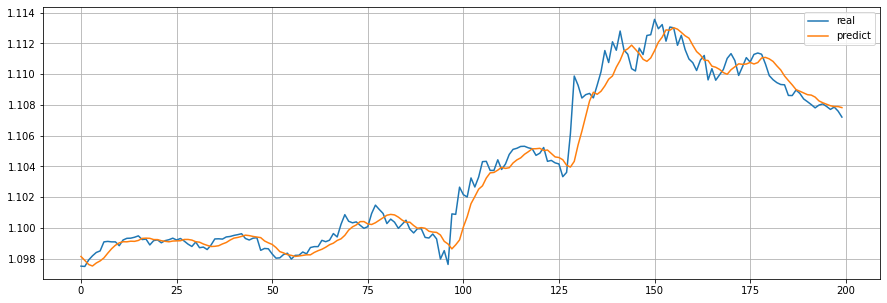

In [17]:
''' --- Множественная регрессия --- '''
y_full = data['<OPEN>'].reset_index(drop = True)
y = y_full[0:10000].reset_index(drop = True)

# y = y.diff().dropna().reset_index(drop = True)

# Сплит данных
start, num_pred = 1, 5
Y_pred_arr = []
for i in range(start, num_pred + start): 
    lag_start, lag_end = i, 20 + num_pred
    X_train, Y_train, X_test, Y_test = prepareData(y, lag_start = lag_start, lag_end = lag_end, test_size = 0.25)
    lr = sklm.LinearRegression()
    lr.fit(X_train, Y_train)
    Y_pred_arr.append(lr.predict(X_test))
Y_pred_arr = np.array(Y_pred_arr)

Y_pred = Y_pred_arr.mean(axis = 0)
# Погрешность
print(mean_squared_error(Y_test, Y_pred), mean_absolute_error(Y_test[:200], Y_pred[:200]))

nice_plot([Y_test[:200], Y_pred[:200]], ['real', 'predict'])

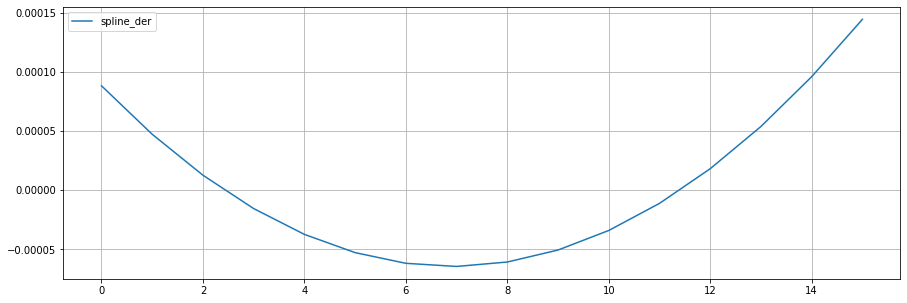

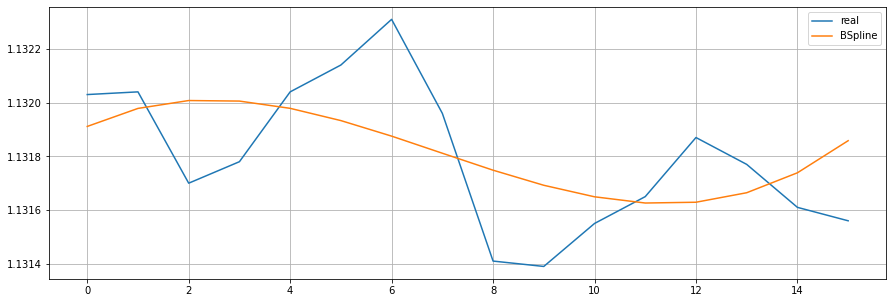

In [175]:
''' --- Кубический сплайн --- '''
move = 10
y_full = data['<OPEN>'].reset_index(drop = True)
# y_full = y_full.diff().dropna().reset_index(drop = True)

y = np.array(y_full[move:15 + move + 1].reset_index(drop = True))
x = np.arange(y.shape[0])
tck = spi.splrep(x[:-1], y[:-1], s = 1)

y_spl = spi.splev(x, tck, der = 0)
y_spl1 = spi.splev(x, tck, der = 1)

nice_plot([y_spl1], ['spline_der'])
nice_plot([y, y_spl], ['real', 'BSpline'])

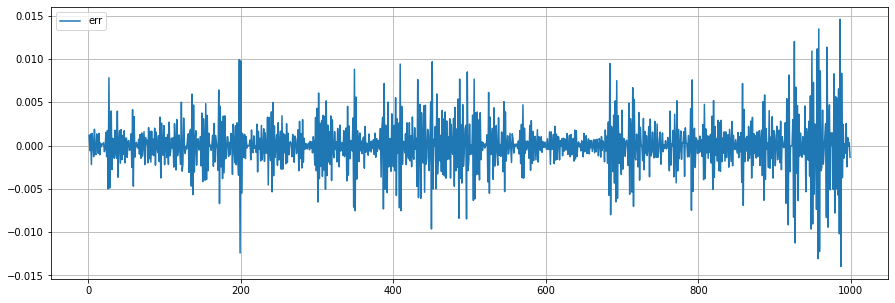

In [65]:
y_full = data['<OPEN>'].reset_index(drop = True)
# y_full = y_full.diff().dropna().reset_index(drop = True)
x = np.arange(10 + 1)

err = []
for move in range(1000):
    y = np.array(y_full[move:10 + move + 1].reset_index(drop = True))
    cs = spi.CubicSpline(x[:-1], y[:-1])
    cs_vals = cs(x)
    err.append(y[-1] / cs_vals[-1])
err = pd.Series(err)
nice_plot([err.diff()], ['err'])

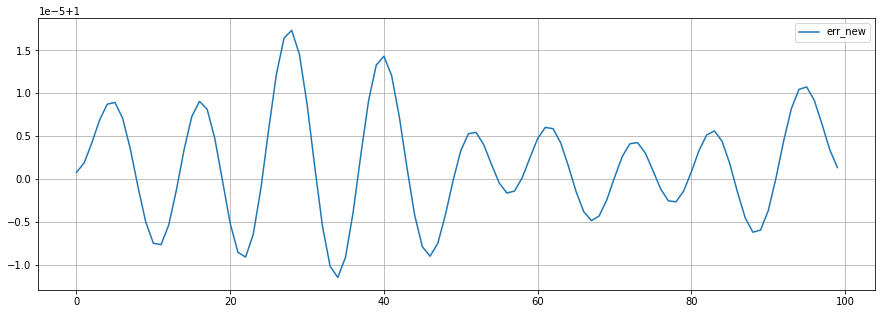

In [54]:
err_ft = spfft.rfft(err)
err_ft[10:] = 0
err_new = spfft.irfft(err_ft)
nice_plot([err_new], ['err_new'])